# Black Sea altimetry interpolation.
Application demonstrating the use of `DIVAnd` on along-track altimetry measurements in the Black Sea.

In [77]:
using DIVAnd
using NCDatasets
using PyPlot
using Dates
using Distances
push!(LOAD_PATH, "/home/ctroupin/Projects/Altimetry-Interpolation/julia")
using DivandAltimetry
using Revise

## User inputs

In [61]:
datadir = "../data/SEALEVEL_BS_PHY_L3_NRT_OBSERVATIONS_008_039/";
datadir2 = "../data/SEALEVEL_BS_PHY_L4_NRT_OBSERVATIONS_008_041/dataset-duacs-nrt-blacksea-merged-allsat-phy-l4/";
figdir = "./figures/"
isdir(figdir) ? @info("$(figdir) already exists") : mkdir(figdir)

"./figures/"

### Domain of interest, resolution
The goal is to take the same grid as the L4 (gridded) products.

In [28]:
avisoL4file = "../data/nrt_blacksea_allsat_phy_l4_20190601_20190607.nc"
gridval,griderr,gridlon,gridlat,timeL4 = DivandAltimetry.loadaviso_gridded(avisoL4file);
gridval = coalesce.(gridval, NaN);

Plot the grid

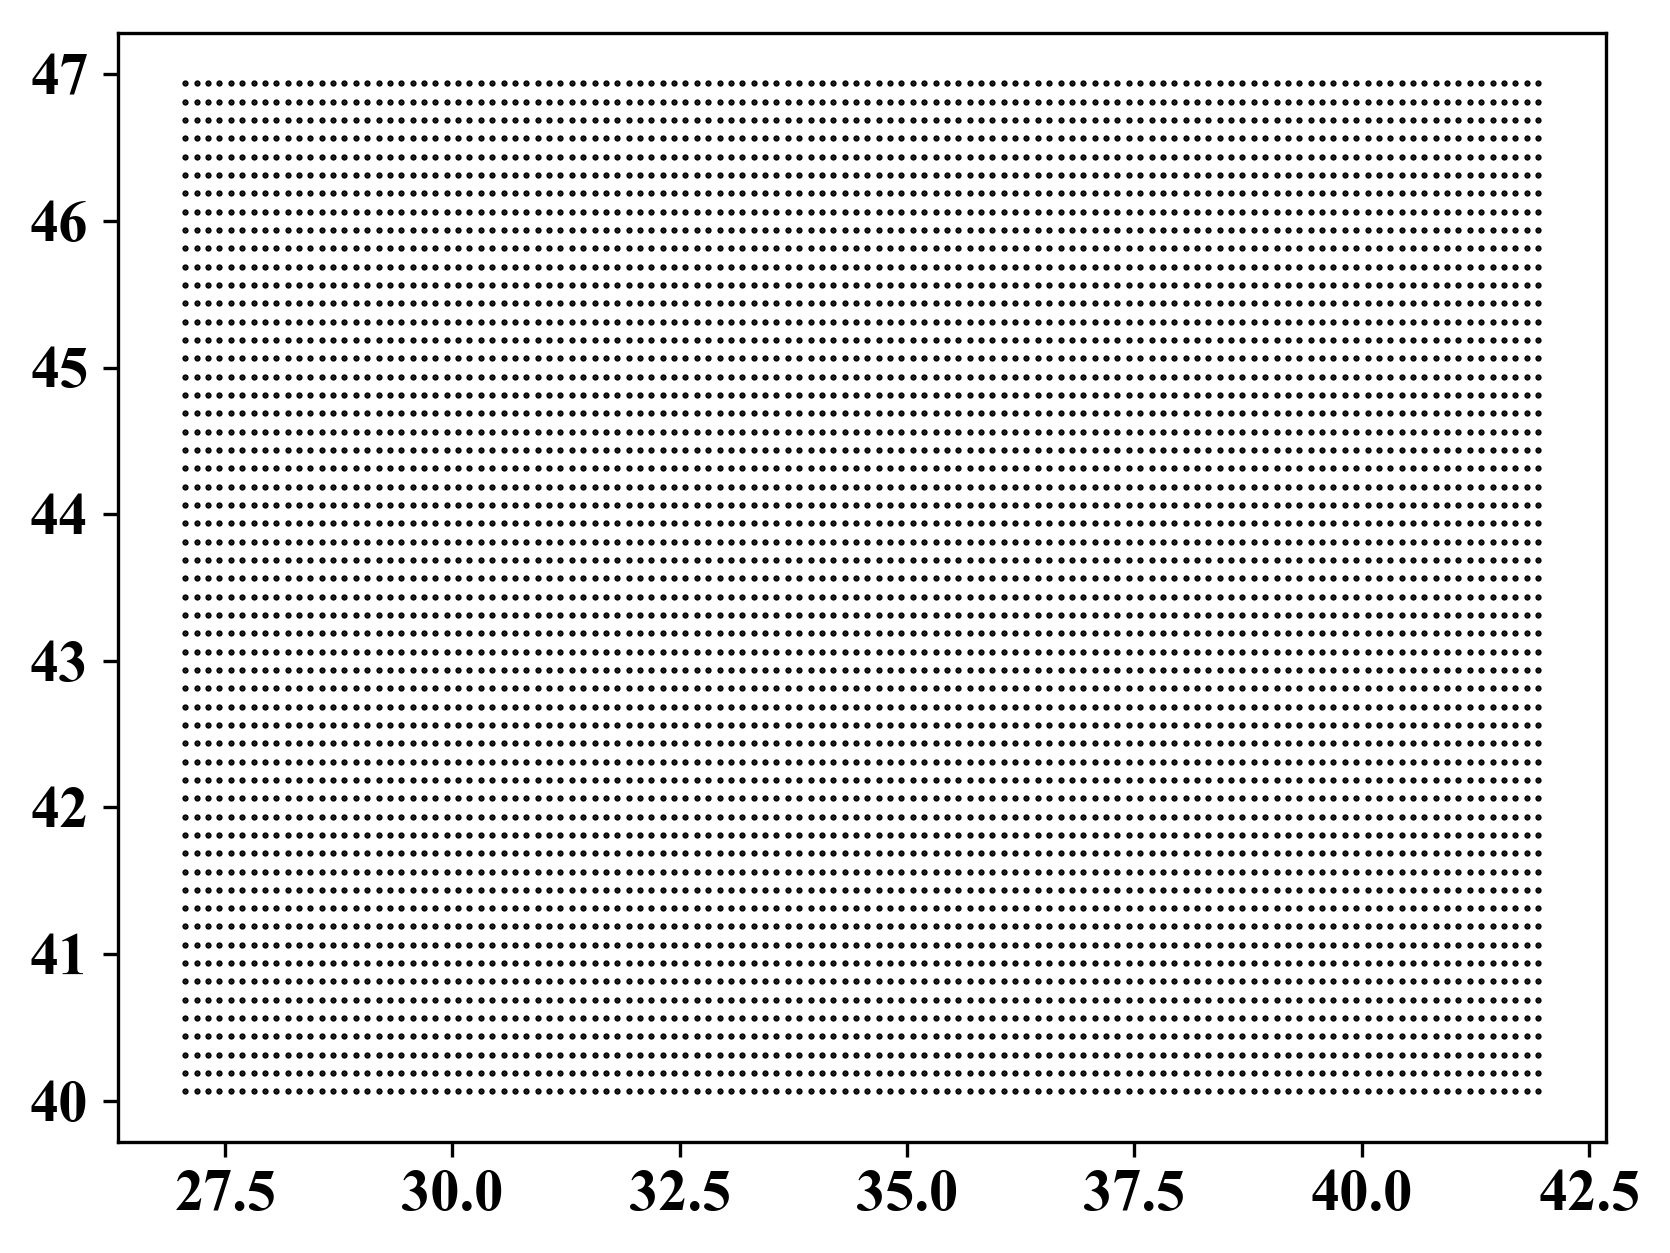

In [4]:
llon, llat = DIVAnd.ndgrid(gridlon, gridlat);
PyPlot.plot(llon, llat, "ko", ms=0.5);

### Period of interest

In [63]:
datestart = DateTime(2018, 1, 1)
dateend = DateTime(2018, 2, 28)
Δt = 1.
timestart = datestart.instant.periods.value / (24 * 3600. * 1000.);
timeend = dateend.instant.periods.value / (24 * 3600. * 1000.);
gridtime = timestart:Δt:timeend;
@info(length(gridtime));

┌ Info: 59
└ @ Main In[63]:7


### Land-sea mask

In [50]:
bathfile = "../data/gebco_30sec_4.nc";

In [64]:
xi,yi,mask = load_mask(bathfile,true,gridlon, gridlat, 0.0);
@info(size(mask));
masktime = repeat(mask, 1, 1, length(gridtime));
@info(size(masktime))

┌ Info: (120, 56)
└ @ Main In[64]:2
┌ Info: (120, 56, 59)
└ @ Main In[64]:4


Plot land-sea mask and grid

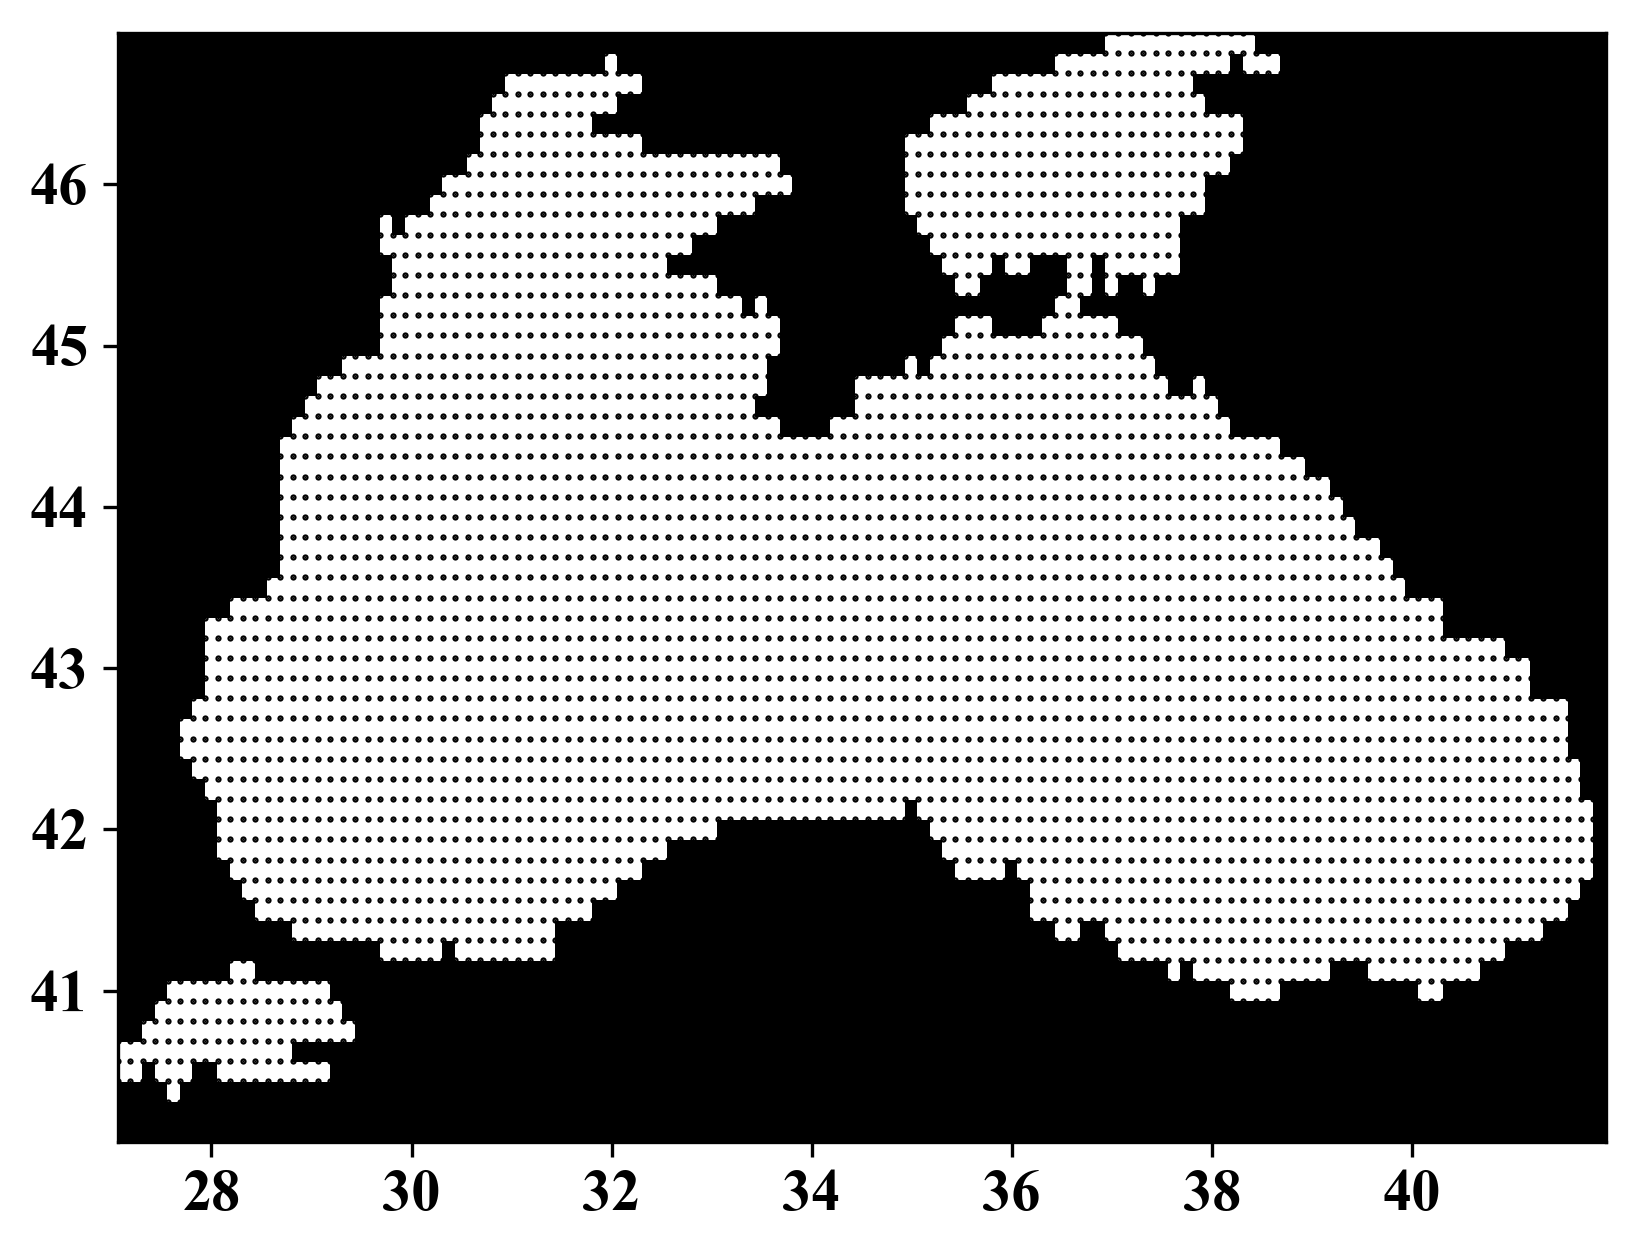

In [52]:
PyPlot.plot(llon, llat, "ko", ms=0.5)
PyPlot.pcolormesh(xi, yi, transpose(mask), cmap=PyPlot.cm.binary_r)
PyPlot.show()

### Along-track SLA

In [53]:
filelist2017 = DivandAltimetry.get_file_list(datadir, 2017);
filelist2018 = DivandAltimetry.get_file_list(datadir, 2018);

┌ Info: Found 930 files
└ @ DivandAltimetry /home/ctroupin/Projects/Altimetry-Interpolation/julia/DivandAltimetry.jl:46
┌ Info: Found 1342 files
└ @ DivandAltimetry /home/ctroupin/Projects/Altimetry-Interpolation/julia/DivandAltimetry.jl:46


Read all the measurements from the file list

In [54]:
@time obsvallist,obslonlist,obslatlist,obstimelist = DivandAltimetry.loadaviso_alongtrack(filelist2018);
@info("Working on $(length(obslatlist)) data points")

  1.022232 seconds (1.89 M allocations: 1.878 GiB, 18.98% gc time)


┌ Info: Working on 82365 data points
└ @ Main In[54]:2


Convert dates to number of days

In [55]:
obstime = [dd.instant.periods.value / (24 * 3600. * 1000.) for dd in obstimelist];

### Metrics

In [67]:
_, (px, py, pt), (xi, yi, ti) = DIVAnd.DIVAnd_rectdom(gridlon, gridlat, gridtime);

## Interpolation
### Analysis Parameters

In [68]:
# correlation length (lon, lat in degrees, time in days)
len = (.5, .5, 5.);
# obs. error variance normalized by the background error variance
epsilon2 = 0.1;

In [69]:
mask0 = trues(size(px));
size(pt)

(120, 56, 59)

### Select time of interest

In [70]:
sel = findall(Dates.month.(obstimelist) .<= 3);

### Run DIVAnd

In [71]:
@time sla_grid, s = DIVAnd.DIVAndrun(masktime, (px, py, pt), (xi, yi, ti), 
    (obslonlist[sel], obslatlist[sel], obstime[sel]), 
     obsvallist[sel], len, epsilon2; alphabc=2);

130.110740 seconds (4.55 k allocations: 14.703 GiB, 3.60% gc time)


## Compute RMS

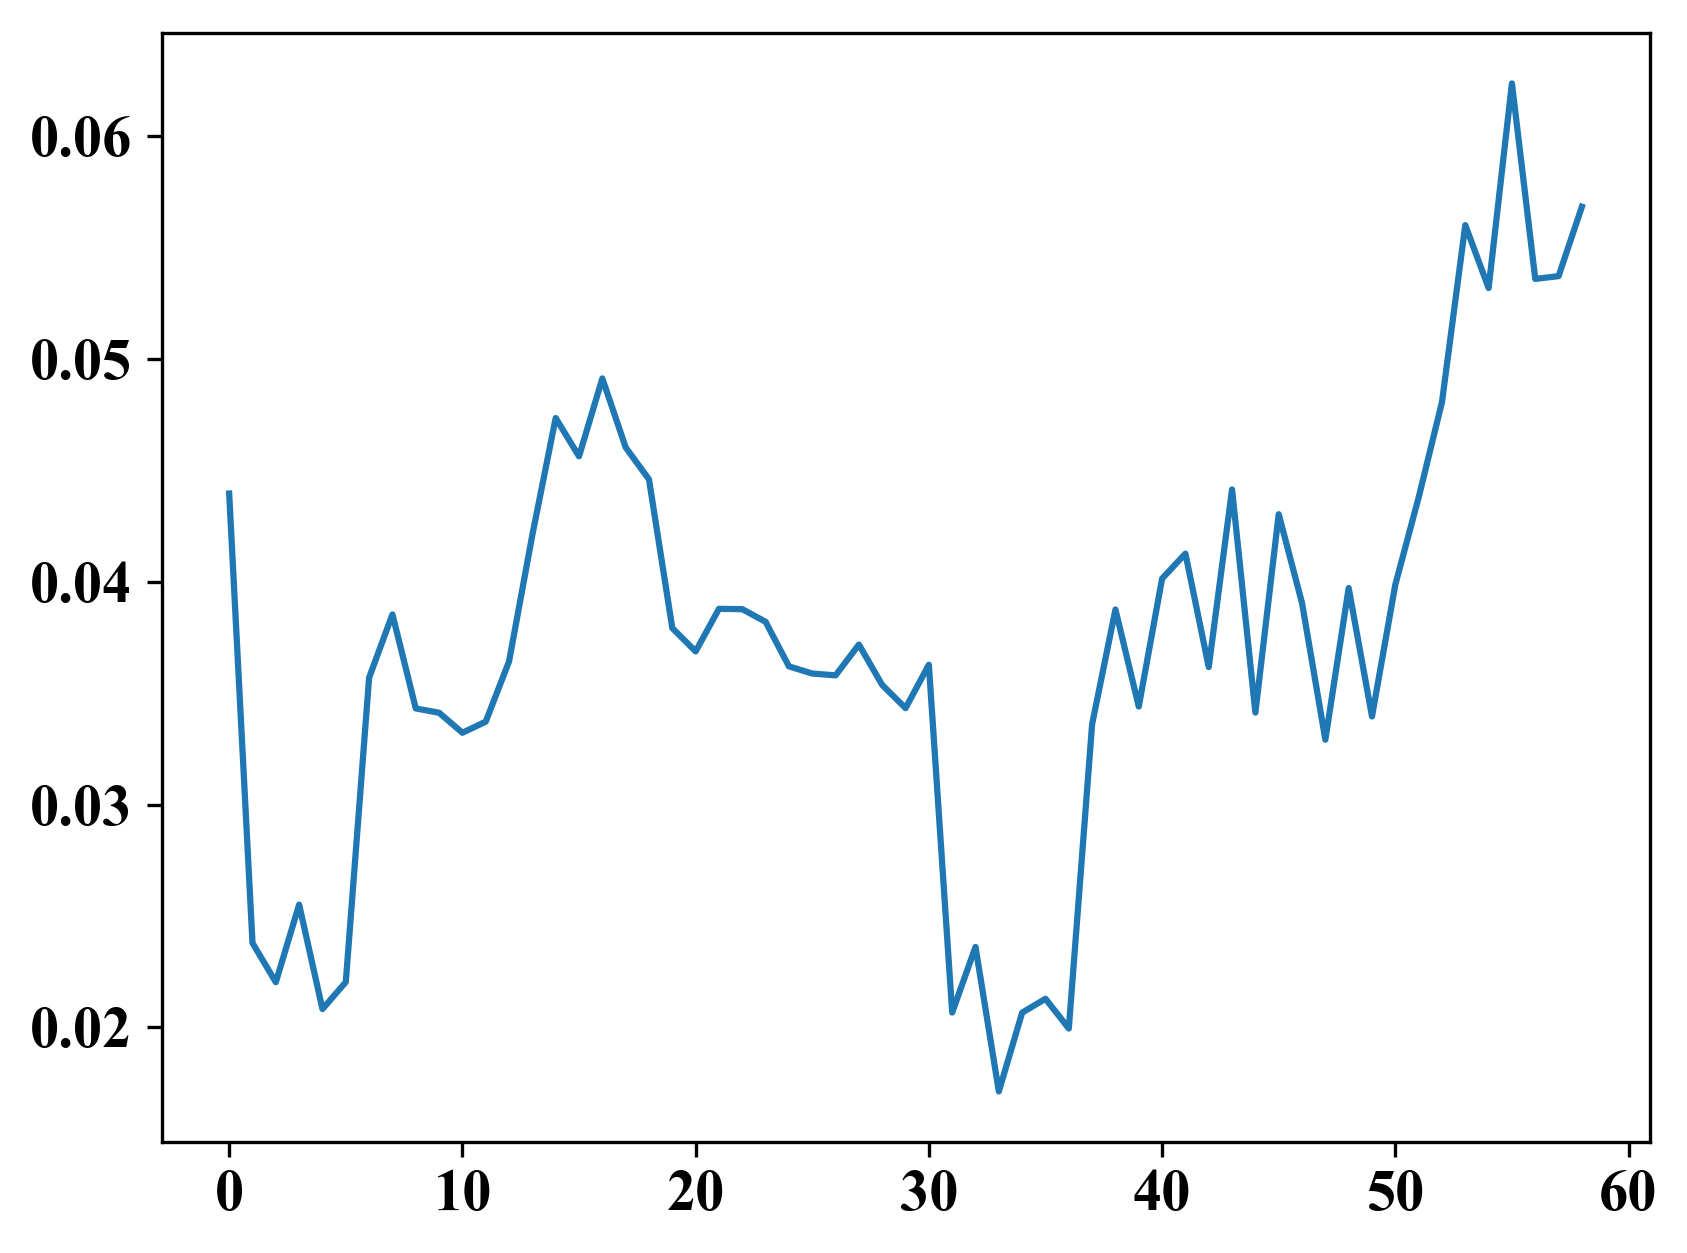

In [97]:
# Loop on time
dateref = DateTime(1, 1, 1)
rmsdiff = zeros(length(gridtime))
for (iday, day) in enumerate(gridtime)
    @debug(day)
    datafileL4, datestring2 = get_filename_L4(day, datadir2);
    @debug("Working in gridded file $(basename(datafileL4))")
    gridval,griderr,gridlon,gridlat,timeL4 = DivandAltimetry.loadaviso_gridded(datafileL4);
    
    # Consider only points that are not NaN
    sla_diva = sla_grid[:,:,iday]
    sel = (.!isnan.(sla_diva)) .& (.!isnan.(gridval))
    
    sladiff = sla_diva[sel] .- gridval[sel]
    
    rmsdiff[iday] = rmsd(sla_diva[sel], gridval[sel])
end

PyPlot.plot(rmsdiff)
PyPlot.show()

## Plotting

In [62]:
# Loop on time
dateref = DateTime(1, 1, 1)
for (iday, day) in enumerate(gridtime)
    @debug(day)
    datafileL4, datestring2 = DivandAltimetry.get_filename_L4(day, datadir2);
    @debug("Working in gridded file $(basename(datafileL4))")
    gridval,griderr,gridlon,gridlat,timeL4 = DivandAltimetry.loadaviso_gridded(datafileL4);
    
    PyPlot.figure()
    PyPlot.suptitle(datestring2)
    PyPlot.subplot(211)
    PyPlot.pcolormesh(gridlon, gridlat, transpose(sla_grid[:,:,iday]), cmap=PyPlot.cm.RdBu_r, vmin=0., vmax=0.25)
    PyPlot.title("DIVAnd")
    PyPlot.colorbar(extend="both")
    
    PyPlot.subplot(212)
    PyPlot.pcolormesh(gridlon, gridlat, transpose(gridval), cmap=PyPlot.cm.RdBu_r, vmin=0., vmax=0.25)
    PyPlot.title("AVISO")
    PyPlot.colorbar(extend="both")
    PyPlot.savefig(joinpath(figdir, "SLA_comparison_$(datestring2).png"), dpi=300, bbox_inches="tight")
    
    PyPlot.close()
    
end

┌ Info: Working in gridded file nrt_blacksea_allsat_phy_l4_20180101_20180107.nc
└ @ Main In[62]:6
┌ Info: Working in gridded file nrt_blacksea_allsat_phy_l4_20180102_20180108.nc
└ @ Main In[62]:6
┌ Info: Working in gridded file nrt_blacksea_allsat_phy_l4_20180103_20180109.nc
└ @ Main In[62]:6
┌ Info: Working in gridded file nrt_blacksea_allsat_phy_l4_20180104_20180110.nc
└ @ Main In[62]:6
┌ Info: Working in gridded file nrt_blacksea_allsat_phy_l4_20180105_20180111.nc
└ @ Main In[62]:6
┌ Info: Working in gridded file nrt_blacksea_allsat_phy_l4_20180106_20180112.nc
└ @ Main In[62]:6
┌ Info: Working in gridded file nrt_blacksea_allsat_phy_l4_20180101_20180107.nc
└ @ Main In[62]:6
┌ Info: Working in gridded file nrt_blacksea_allsat_phy_l4_20180102_20180108.nc
└ @ Main In[62]:6
┌ Info: Working in gridded file nrt_blacksea_allsat_phy_l4_20180103_20180109.nc
└ @ Main In[62]:6
┌ Info: Working in gridded file nrt_blacksea_allsat_phy_l4_20180104_20180110.nc
└ @ Main In[62]:6
┌ Info: Working in g

### Gradients

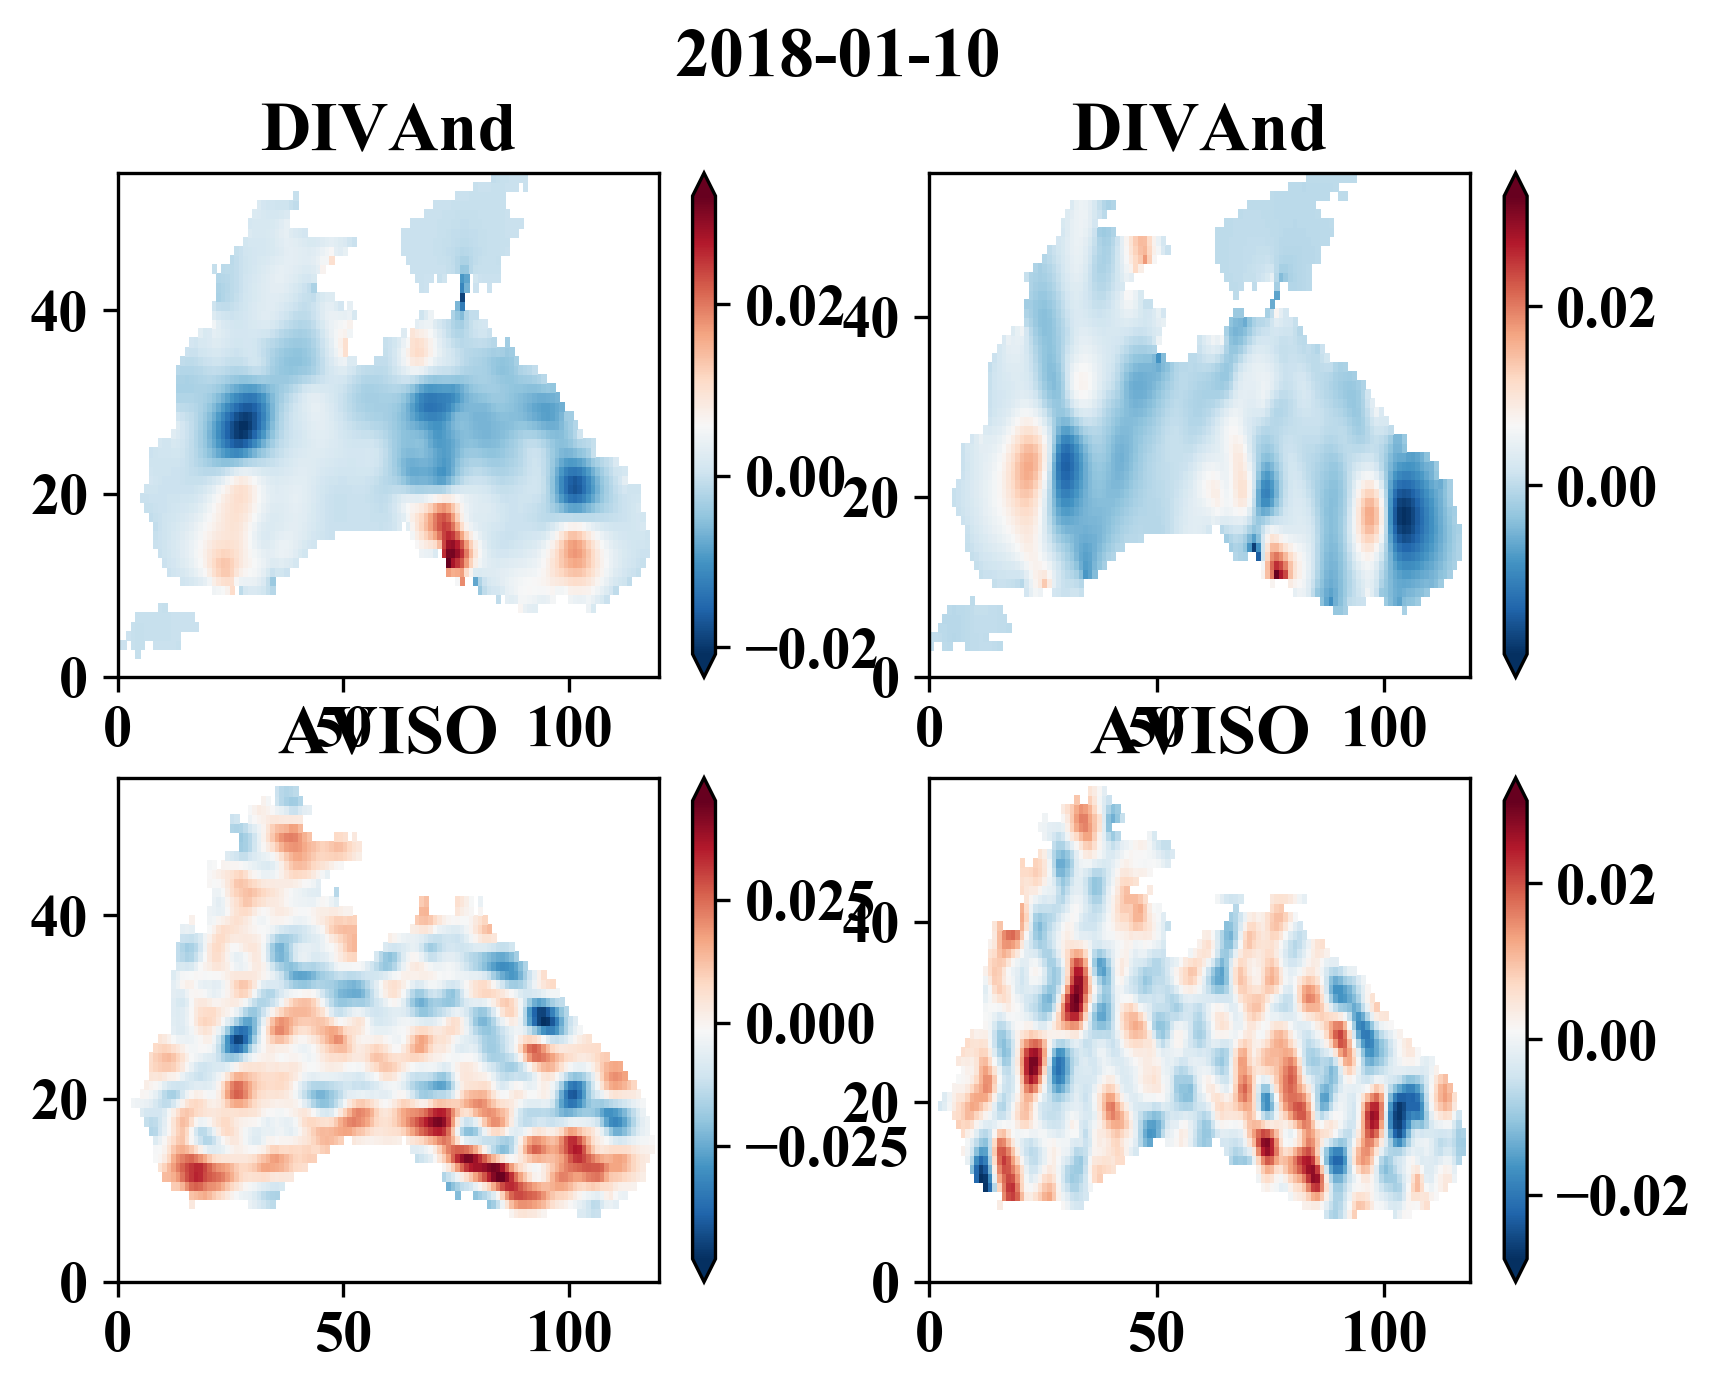

In [101]:
# Loop on time
dateref = DateTime(1, 1, 1)
for (iday, day) in enumerate(gridtime[10:10])
    @debug(day)
    datafileL4, datestring2 = get_filename_L4(day, datadir2);
    @debug("Working in gridded file $(basename(datafileL4))")
    gridval,griderr,gridlon,gridlat,timeL4 = DivandAltimetry.loadaviso_gridded(datafileL4);
    
    sla_diva = sla_grid[:,:,iday]
    
    # Compute gradients
    gradX1, gradY1 = DivandAltimetry.gradient2D(sla_diva);
    gradX2, gradY2 = DivandAltimetry.gradient2D(gridval);
    
    PyPlot.figure()
    PyPlot.suptitle(datestring2)
    
    PyPlot.subplot(221)
    PyPlot.pcolormesh(transpose(gradX1), cmap=PyPlot.cm.RdBu_r,)
    PyPlot.title("DIVAnd")
    PyPlot.colorbar(extend="both")
    
    PyPlot.subplot(222)
    PyPlot.pcolormesh(transpose(gradY1), cmap=PyPlot.cm.RdBu_r,)
    PyPlot.title("DIVAnd")
    PyPlot.colorbar(extend="both")
    
    PyPlot.subplot(223)
    PyPlot.pcolormesh(transpose(gradX2), cmap=PyPlot.cm.RdBu_r)
    PyPlot.title("AVISO")
    PyPlot.colorbar(extend="both")
    
    PyPlot.subplot(224)
    PyPlot.pcolormesh(transpose(gradY2), cmap=PyPlot.cm.RdBu_r)
    PyPlot.title("AVISO")
    PyPlot.colorbar(extend="both")
    
    
    
    #PyPlot.savefig(joinpath(figdir, "SLA_comparison_$(datestring2).png"), dpi=300, bbox_inches="tight")
    
    #PyPlot.close()
    
end

## Export results to netCDF

In [20]:
info("Writing interpolated field in file:\n", resultfile)
sz = size(mask)
dims = [NcDim("longitude",sz[1]), NcDim("latitude",sz[2]), NcDim("time",sz[3])];
nc = NetCDF.create(resultfile, NcVar("ADT", dims))
nc["ADT"][:,:, :] = fi
NetCDF.close(nc);

UndefVarError: UndefVarError: info not defined

# Plotting

Done in [another notebook in Python](../python/plot_AVISO_divand.ipynb) due to a problem with Julia / matplotlib.